## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

In [2]:
df = pd.read_csv('water_potability_AdityaKadiwal.csv')

In [3]:
fillWithMean = df.apply(lambda col: col.fillna(col.mean()), axis=0)

### For this we will use the 'mean' approach

In [4]:
# Use the remove_null DataFrame, not the original DataFrame (df)
X = fillWithMean.drop(columns=['Potability'])
y = fillWithMean['Potability']

### Normalization and Standardiztion  
Since we will likely leverage Linear or Logistic regression, we must first Scale our dataset.  
Otherwise features with larger values will throw off our model (gradient calculation).

### When we don't care about Scaling:  
- distance-based algorithms
- tree-base algorithms
Examples:
  - K-Means Clustering
  - Support Vector Machines
  - K Nearest Neighbors
  - decision trees
  - random forest
  - XG-Boost

#### Additional notes on Normalization vs Standardization  
- Which to do? Generally, there is no right or wrong answer.
- In case of neural networks, normalization is preferred since we don't assume any data distribution.
- Standardization is preferred when data follows *gaussian* or *normal* distribution.
- Standardization is preferred over normalization when there is a lot of outliers.

### Before we change the dataset in any way:  
- Separate the features from the target
- Perfrom train,test,split

In [5]:
from sklearn.model_selection import train_test_split
# For feature matrix X and target variable y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### I'm not sure if Normalization or Standardization is needed for models but we will apply  
### it here for the feature selection process.

#### Standardize

In [7]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
Xstd = stdscaler.fit_transform(X)

In [10]:
# StandardScaler produces a numpy array which we must turn back to a DataFrame
Xstd = pd.DataFrame(X, columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'])

#### Normalize

In [12]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
Xmm = mmscaler.fit_transform(X)

In [13]:
# MinMaxScaler produces a numpy array which we must turn back to a DataFrame
Xmm = pd.DataFrame(X, columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'])

### Resources, References  
[Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

#### Let's leverage some methods to see if we can remove features from our model  
#### We will consider:  
1. Correlation
2. Variance

#### Let's view and consider a correlation matrix  
Perhaps this will help us find those variables with a linear correlation each other.  
Or, with the target.

### For here on we will only test the StandardScaler version 'Xstd'  
#### we can return later to test the other if desired.

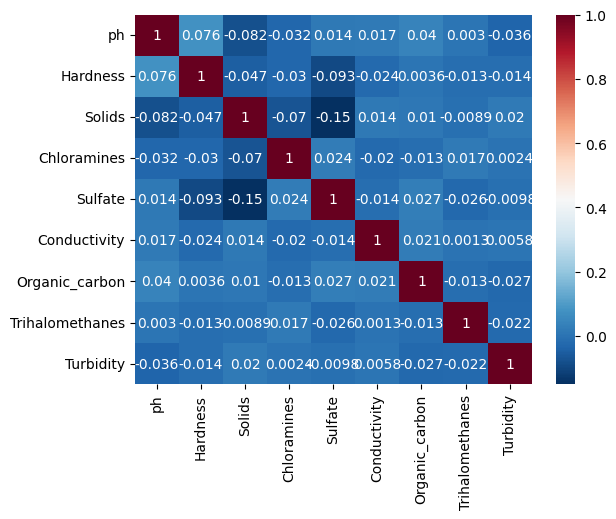

In [15]:
# First let's check correlation between features
import matplotlib.pyplot as plt

corr_matrix = Xstd.corr(method='pearson') # pearson is default

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [16]:
for i in range(len(corr_matrix.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix.iloc[i, j]) > 0.1:
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])   

Sulfate Solids -0.14983986940343325


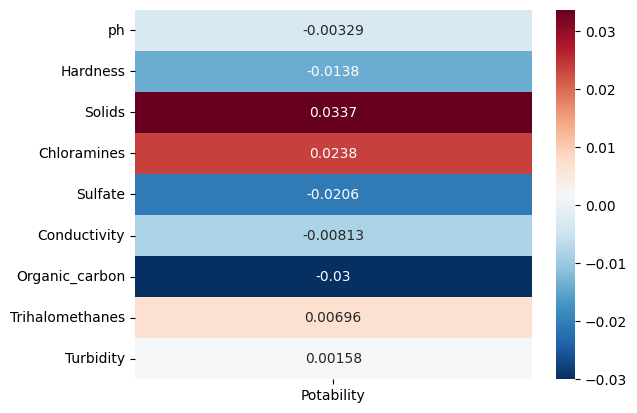

In [17]:
# Now we'll check for correlation with the traget.
X_y = Xstd.copy()
X_y['Potability'] = y

corr_matrix = X_y.corr()

# Isolate the column corresponding to 'exam_score'
corr_target = corr_matrix[['Potability']].drop(labels=['Potability'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [18]:
# Get the absolute values of the correlations
corr_target_abs = corr_target.abs()

# Sort the features by their correlation with the target
sorted_features = corr_target_abs.sort_values(by='Potability', ascending=False)

# Print the sorted features
print(sorted_features)

                 Potability
Solids             0.033743
Organic_carbon     0.030001
Chloramines        0.023779
Sulfate            0.020619
Hardness           0.013837
Conductivity       0.008128
Trihalomethanes    0.006960
ph                 0.003287
Turbidity          0.001581


### From the heat maps we can see:  
- Absolute values of Solids & Organic_carbon have the most correllation to the target.
- Sulfates & Solids are the features most closely correllated to one another.
### Conclusion:  
- We can try just using [Solids, Organic_carbon, Chloramines, and Sulfates in our model testing.  
- The other features are .01 or less correllated to the target and thus may have little to no effect on prediction.

## Let's consider other filter methods:

  ### Mutual Information

In [20]:
Xstd.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

[Enjoy Machine Learning - ML:101: Feature Selection with SelectKBest](https://enjoymachinelearning.com/blog/feature-selection-selectkbest-sklearn/)

In [28]:
from sklearn.feature_selection import SelectKBest

# for classification, we use these three
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# this function will take in X, y variables 
# with criteria, and return a dataframe
# with most important columns
# based on that criteria
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X

New_X = featureSelect_dataframe(Xstd, y, chi2, 5)

New_X

,Hardness,Solids,Sulfate,Conductivity,Organic_carbon
0,204.890455,20791.318981,368.516441,564.308654,10.379783
1,129.422921,18630.057858,333.775777,592.885359,15.180013
2,224.236259,19909.541732,333.775777,418.606213,16.868637
3,214.373394,22018.417441,356.886136,363.266516,18.436524
4,181.101509,17978.986339,310.135738,398.410813,11.558279
...,...,...,...,...,...
3271,193.681735,47580.991603,359.948574,526.424171,13.894419
3272,193.553212,17329.802160,333.775777,392.449580,19.903225
3273,175.762646,33155.578218,333.775777,432.044783,11.039070
3274,230.603758,11983.869376,333.775777,402.883113,11.168946


In [29]:
New_X = featureSelect_dataframe(Xstd, y, f_classif, 5)

New_X

,Hardness,Solids,Chloramines,Sulfate,Organic_carbon
0,204.890455,20791.318981,7.300212,368.516441,10.379783
1,129.422921,18630.057858,6.635246,333.775777,15.180013
2,224.236259,19909.541732,9.275884,333.775777,16.868637
3,214.373394,22018.417441,8.059332,356.886136,18.436524
4,181.101509,17978.986339,6.546600,310.135738,11.558279
...,...,...,...,...,...
3271,193.681735,47580.991603,7.166639,359.948574,13.894419
3272,193.553212,17329.802160,8.061362,333.775777,19.903225
3273,175.762646,33155.578218,7.350233,333.775777,11.039070
3274,230.603758,11983.869376,6.303357,333.775777,11.168946


In [30]:
New_X = featureSelect_dataframe(Xstd, y, mutual_info_classif, 5)

New_X

,Hardness,Sulfate,Conductivity,Organic_carbon,Turbidity
0,204.890455,368.516441,564.308654,10.379783,2.963135
1,129.422921,333.775777,592.885359,15.180013,4.500656
2,224.236259,333.775777,418.606213,16.868637,3.055934
3,214.373394,356.886136,363.266516,18.436524,4.628771
4,181.101509,310.135738,398.410813,11.558279,4.075075
...,...,...,...,...,...
3271,193.681735,359.948574,526.424171,13.894419,4.435821
3272,193.553212,333.775777,392.449580,19.903225,2.798243
3273,175.762646,333.775777,432.044783,11.039070,3.298875
3274,230.603758,333.775777,402.883113,11.168946,4.708658


### SelectKBest

In [31]:
from sklearn.feature_selection import SelectKBest
from functools import partial

score_func = partial(mutual_info_classif, random_state=68)

# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=3)

print(selection.fit_transform(Xstd, y))

[[  7.0807945  204.89045547 564.30865417]
 [  3.71608008 129.42292051 592.88535913]
 [  8.09912419 224.23625939 418.60621306]
 ...
 [  9.41951032 175.7626463  432.04478305]
 [  5.12676292 230.60375751 402.88311312]
 [  7.87467136 195.10229859 327.45976046]]


In [32]:
Xstd = Xstd[Xstd.columns[selection.get_support(indices=True)]]

print(Xstd)

            ph    Hardness  Conductivity
0     7.080795  204.890455    564.308654
1     3.716080  129.422921    592.885359
2     8.099124  224.236259    418.606213
3     8.316766  214.373394    363.266516
4     9.092223  181.101509    398.410813
...        ...         ...           ...
3271  4.668102  193.681735    526.424171
3272  7.808856  193.553212    392.449580
3273  9.419510  175.762646    432.044783
3274  5.126763  230.603758    402.883113
3275  7.874671  195.102299    327.459760

[3276 rows x 3 columns]
